# Hackathon Project: Environmental Data Analysis for Decision-making

## Introduction

Welcome to our hackathon project! In this Jupyter Notebook, we embark on a journey to analyze various environmental datasets to extract meaningful insights. The main objective is to make data-driven decisions related to environmental concerns such as weather patterns, land-use, and hotspot activities.

## Datasets Used

1. **Alum Classes** - Contains geo-spatial data related to different alum classes.
2. **DEM (Digital Elevation Model)** - Provides topographical information.
3. **Hotspots** - Includes satellite data about geographical hotspots.
4. **MODIS MCD12C1 Land-use Classification** - Contains land-use categories.
5. **ERA5 Hourly Weather Data** - Provides hourly weather data.
6. **AGCD (Australian Gridded Climate Data)** - Contains daily weather data.
7. **BARRA Hourly Weather Data** - Another source of hourly weather data.

## Tools and Libraries

- GDAL for geo-spatial data manipulation
- NetCDF for multi-dimensional data storage
- Pandas for data manipulation and analysis
- Matplotlib for data visualization
- Xarray for handling labeled multi-dimensional arrays

## Structure of the Notebook

The notebook is structured into several parts, each focusing on a different aspect of environmental data:

1. **Data Reading and Pre-processing** - Importing and cleaning data.
2. **Data Transformation and Projection** - Converting data into desired formats and projections.
3. **Data Filtering and Subsetting** - Narrowing down the datasets based on certain criteria such as Region of Interest (ROI) and time periods.
4. **Data Visualization** - Plotting the datasets for visual interpretation.
5. **Data Analysis** - Extracting meaningful insights from the data.

Let's get started!

## Hackathon Notebook

In [1]:
## Some settings

# If you are running this notebook on one of the UoM Jupyterhubs, set the following variable to True, otherwise False (i.e., if working on another system)
running_on_uom_jupyterhub = True

# Do you want to plot things here (in the notebook), or save figures to file?
plot_figs_here = True

Add packages to your local setup

In [2]:
# set up a directory for the packages
!mkdir -p ~/packages

In [3]:
# add this directory to your Python path
import sys
sys.path.append('~/packages')

In [ ]:
# add a package using pip
!pip install packageyouwouldlike --target=~/packages

In [2]:
# Importing libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import xarray
import dask
import os
import glob
import gzip
import cftime
import time
import io
import osgeo

# Importing libraries for geospatial data
from osgeo import ogr
from osgeo import gdal
from osgeo import osr
import geopandas as gpd
import rasterio as rio
from shapely.geometry import Point

# Importing libraries for visualization
from matplotlib import pyplot as plt

# Importing library for working with netCDF files
import netCDF4 as nc

In [3]:
## if running on a UoM Jupyterhub, set up some things
if running_on_uom_jupyterhub:
    # We are assuming all of the datasets are under a subfolder of the current working directory called 'data'
    # note that this can be a symbolic link.
    #    
    # set up a link to the data directory:
    if not os.path.exists('data'):
        ## only create the symbolic link if the path does not already exist
        os.symlink('/mnt/mediaflux_fires_dataset/MCDS_fire_datasets','data')
    #
    # get some of the geoprocessing libraries (gdal, proj) to play nicely
    gdal.SetConfigOption("GTIFF_SRS_SOURCE", "EPSG")
    # specify the path to the 'proj' library
    os.environ['PROJ_LIB'] = '/opt/conda/envs/python/share/proj'

## Define Region of Interest (ROI) and Study Period
In this section, we define the geographic boundaries and time frame for our study. We have two options for geographic scope: Victoria or Australia as a whole.

In [4]:
# If just_roi is True, use Victoria's bounding box, else use Australia's bounding box
just_roi = True

if just_roi:
    # Box around Victoria (coordinates found using https://boundingbox.klokantech.com/)
    roi_lon_bounds = [140.53, 150.03]
    roi_lat_bounds = [-39.20, -33.73]
else:
    # Box around Australia
    roi_lon_bounds = [106.3, 160.8]
    roi_lat_bounds = [-44.2,  -8.9]

# Define the study period
study_period_bounds = [
    pd.Timestamp('2020-01-01T00:00:00', tz='UTC'), 
    pd.Timestamp('2020-02-01T00:00:00', tz='UTC')
]

## Load ALUM Land-Use Data

Here, we load the ALUM land-use data from a CSV file and a TIFF file. We use the GDAL library to read the TIFF data.

In [5]:
# Read metadata from CSV file
alum_metadata = pd.read_csv('data/ALUM/NLUM_ALUMV8_250m_2015_16_alb/NLUM_ALUMV8_250m_2015_16_alb.csv')

# Open the TIFF dataset using GDAL
alum_dataset = gdal.Open('data/ALUM/NLUM_ALUMV8_250m_2015_16_alb/NLUM_ALUMV8_250m_2015_16_alb.tif', gdal.GA_ReadOnly)

# Get the first raster band from the dataset
alum_band = alum_dataset.GetRasterBand(1)

## Extract and Transform Geospatial Metadata
In this section, we extract metadata from the ALUM land-use dataset. We also set up coordinate transformations to align the dataset with our Region of Interest (ROI).

In [7]:
## following the example from https://gis.stackexchange.com/a/201320 to read the metadata
alum_ulx, alum_xres, alum_xskew, alum_uly, alum_yskew, alum_yres  = alum_dataset.GetGeoTransform()
alum_nx = alum_dataset.RasterXSize
alum_ny = alum_dataset.RasterYSize
alum_lrx = alum_ulx + (alum_nx * alum_xres)
alum_lry = alum_uly + (alum_ny * alum_yres)
alum_proj = alum_dataset.GetProjection()

# Setup the source projection - you can also import from epsg, proj4...
source = osr.SpatialReference()
source.ImportFromWkt(alum_dataset.GetProjection())

# The target projection
target = osr.SpatialReference()
target.ImportFromEPSG(4326)

# Create the transform - (x,y) to (lat,lon)
transform = osr.CoordinateTransformation(source, target)
# generate the inverse transform
invtransform = osr.CoordinateTransformation(target, source)

# Transform a corner point (for testing purposes)
alum_ulx_lat, alum_ulx_lon, _ = transform.TransformPoint(alum_ulx, alum_uly)

alum_xrow = alum_ulx + np.arange(alum_nx, dtype = np.float64) * alum_xres
alum_ycol = alum_uly + np.arange(alum_ny, dtype = np.float64) * alum_yres

In [9]:
# Extract metadata from the ALUM dataset
alum_ulx, alum_xres, alum_xskew, alum_uly, alum_yskew, alum_yres  = alum_dataset.GetGeoTransform()
alum_nx = alum_dataset.RasterXSize  # Number of columns
alum_ny = alum_dataset.RasterYSize  # Number of rows

# Calculate bottom-right x and y coordinates
alum_lrx = alum_ulx + (alum_nx * alum_xres)
alum_lry = alum_uly + (alum_ny * alum_yres)

# Get the projection details
alum_proj = alum_dataset.GetProjection()

# Initialize source and target spatial references
source = osr.SpatialReference()
source.ImportFromWkt(alum_proj)  # Import from well-known text

target = osr.SpatialReference()
target.ImportFromEPSG(4326)  # WGS84

# Create coordinate transformations
transform = osr.CoordinateTransformation(source, target)
invtransform = osr.CoordinateTransformation(target, source)

# Transform the upper-left corner point to lat, lon for testing
alum_ulx_lat, alum_ulx_lon, _ = transform.TransformPoint(alum_ulx, alum_uly)

# Calculate the x and y coordinates for each pixel
alum_xrow = alum_ulx + np.arange(alum_nx, dtype=np.float64) * alum_xres
alum_ycol = alum_uly + np.arange(alum_ny, dtype=np.float64) * alum_yres


## Calculate ROI in Dataset Coordinates

We need to translate our geographic ROI into pixel coordinates that align with the ALUM dataset. This involves several transformation steps.

In [10]:
# Transform ROI lat, lon to pixel coordinates
roi_xy_points = []
for ix in range(0, 2):
    for iy in range(0, 2):
        px, py, _ = invtransform.TransformPoint(roi_lat_bounds[ix], roi_lon_bounds[iy])
        roi_xy_points.append([px, py])

# Extract the bounds for ROI in dataset coordinates
roi_xy_points_np = np.array(roi_xy_points)
roi_xlim = np.array([roi_xy_points_np[:, 0].min(), roi_xy_points_np[:, 0].max()])
roi_ylim = np.array([roi_xy_points_np[:, 1].min(), roi_xy_points_np[:, 1].max()])
roi_ixlim = np.searchsorted(alum_xrow, roi_xlim)
roi_iylim = alum_ny - np.searchsorted(alum_ycol[::-1], roi_ylim)[::-1]


## Extract and Visualize ROI from Dataset

Finally, we extract the part of the ALUM dataset that corresponds to our ROI and visualize it.


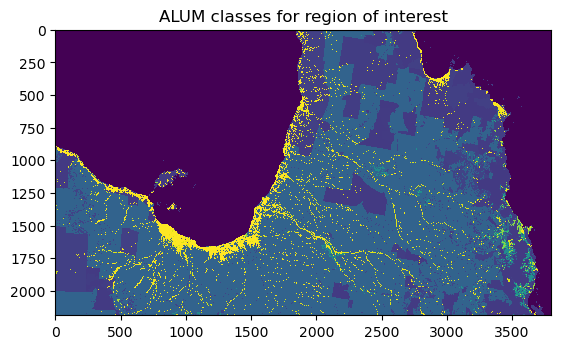

In [38]:
# Read the array data for ROI
alum_roi_nx = int(roi_ixlim[1] - roi_ixlim[0])
alum_roi_ny = int(roi_iylim[1] - roi_iylim[0])
alum_roi_arr = alum_band.ReadAsArray(int(roi_ixlim[0]), int(roi_iylim[0]), alum_roi_nx, alum_roi_ny)

# Plot and save the image
res = plt.imshow(alum_roi_arr, interpolation='nearest')
plt.title('ALUM classes for region of interest')
if not plot_figs_here:
    plt.savefig("alum_classes_roi.png")
    plt.close()

# Calculate x and y coordinates for each pixel in the ROI
alum_roi_xrow = alum_xrow[roi_ixlim[0]] + np.arange(alum_roi_nx, dtype=np.float64) * alum_xres
alum_roi_ycol = alum_ycol[roi_iylim[0]] + np.arange(alum_roi_ny, dtype=np.float64) * alum_yres

# Generate 2D arrays for x and y coordinates
alum_roi_x = np.tile(alum_roi_xrow.reshape((alum_roi_nx, 1)), alum_roi_ny)
alum_roi_y = np.tile(alum_roi_ycol.reshape((alum_roi_ny, 1)), alum_roi_nx).transpose()


## Coordinate Transformation for ROI

In this section, we apply coordinate transformations to the extracted Region of Interest (ROI) from the ALUM dataset. This allows us to convert the dataset's native coordinates into latitude and longitude.

In [30]:
# Apply coordinate transformations to ROI
# Note: This operation can be slow, especially for larger regions
f = lambda x, y: transform.TransformPoint(x, y)
vf = np.vectorize(f)
alum_roi_lat, alum_roi_lon, _ = vf(alum_roi_x, alum_roi_y)


## Load and Transform DEM Data

Here, we load the Digital Elevation Model (DEM) data from a NetCDF file. We also extract the region corresponding to our previously defined ROI and adjust the data for visualization.

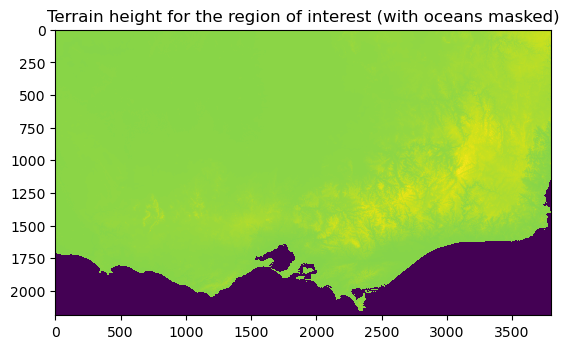

In [45]:
# Load DEM data from NetCDF file
dem_dataset = nc.Dataset('data/DEM/dem-9s.nc')
dem_lon = dem_dataset.variables['lon'][:].data
dem_lat = dem_dataset.variables['lat'][:].data

# Find the DEM indices corresponding to the ROI
roi_ixlim = np.searchsorted(dem_lon, roi_lon_bounds)
roi_iylim = np.searchsorted(dem_lat, roi_lat_bounds)

# Extract DEM data for ROI
dem_roi_arr = dem_dataset.variables['Band1'][roi_iylim[0]:roi_iylim[1], roi_ixlim[0]:roi_ixlim[1]][:].data
dem_dataset.close()

# Flip the vertical orientation for plotting
dem_roi_arr = dem_roi_arr[::-1, :]

# Plot and save the DEM ROI including land and sea
res = plt.imshow(dem_roi_arr, interpolation='nearest')
plt.title('Terrain height for the region of interest (with oceans masked)')
if not plot_figs_here:
    plt.savefig("dem_roi_landsea.png")
    plt.close()

The above plot looks strange because of the value used to mark out ocean areas (-100). Let's try setting this to zero.

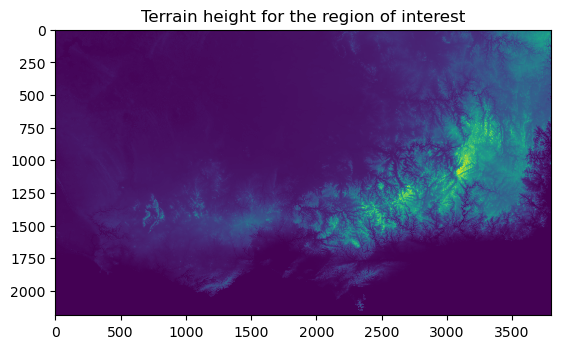

In [46]:
# Replace ocean points (negative values) with zero for better visualization
dem_roi_arr[dem_roi_arr < -100] = 0.0

# Plot and save the modified DEM ROI
res = plt.imshow(dem_roi_arr, interpolation='nearest')
plt.title('Terrain height for the region of interest')
if not plot_figs_here:
    plt.savefig("dem_roi.png")
    plt.close()

## Configure Hotspot Data Reading

In this section, we set up the data types for each column in the hotspot dataset. We also prepare for reading the data in chunks to handle its large size.

In [47]:
# Define data types for each column in the hotspot dataset
dtypes = {
    'id': np.int64,
    'satellite': np.dtype('O'),
    'sensor': np.dtype('O'),
    'latitude': np.float32,
    'longitude': np.float32,
    'temp_kelvin': np.float32,
    'power': np.float32,
    'confidence': np.float32,
    'age_hours': np.int32,
    'australian_state': np.dtype('O')
}

# Initialize variables for chunk-wise reading
nrow_total = 31855161  # Total number of rows in the dataset
n_per_chunk = 1000000  # Number of rows per chunk
n_chunks = int(nrow_total / n_per_chunk) + 1  # Total number of chunks
ichunk = 0  # Current chunk index

hotspot_colnames = [ 'id', 'satellite', 'sensor', 'latitude',
                     'longitude', 'temp_kelvin', 'power', 'confidence', 'datetime',
                     'age_hours', 'australian_state' ]

known_satellites = ['AQUA', 'HIMAWARI-8', 'HIMAWARI-9', 'NOAA17', 'NOAA18', 'NOAA19', 'NOAA 19', 'NOAA 20', 'SUOMI NPP', 'TERRA']

# Open the compressed CSV file for reading
f = gzip.open('data/hotspot/all-data.csv.gz', mode='rt')
header = f.readline().strip().split(',')


## Configure Satellite Filters

Here, we define filters to select which satellites' data to use from the hotspot dataset. Users can opt to use all known satellites or a specified subset.

In [48]:
# Define known and used satellites
known_satellites = ['AQUA', 'HIMAWARI-8', 'HIMAWARI-9', 'NOAA17', 'NOAA18', 'NOAA19', 'NOAA 19', 'NOAA 20', 'SUOMI NPP', 'TERRA']
used_satellites = ['SUOMI NPP', 'AQUA', 'TERRA', 'HIMAWARI-8', 'HIMAWARI-9']  # OR use 'all' to include all known satellites

# Initialize a flag for whether to use all satellites
all_satellites = False

# Validate and set the used_satellites variable
if type(used_satellites) == str:
    if used_satellites == 'all':
        all_satellites = True
    else:
        if used_satellites in known_satellites:
            used_satellites = [used_satellites]
        else:
            raise RuntimeError(f"Satellite {used_satellites} not in known types...")
else:
    assert type(used_satellites) == list, "used_satellites should be of 'list' or 'str' type"
    used_satellites = list(set(used_satellites))
    assert all([s in known_satellites for s in used_satellites]), "Some values in 'used_satellites' are not in 'known_satellites'"
    
    if len(used_satellites) == len(known_satellites):
        all_satellites = True

## Read and Filter Hotspot Data in Chunks

In this section, we read the hotspot dataset in chunks since it's a large file. We then apply filters to keep only the relevant rows based on the defined Region of Interest (ROI), study period, and selected satellites.

In [49]:
# Initialize list to store valid chunks of data
valid_chunks = []

# Initialize chunk index and read settings
ichunk = 0
n_chars_per_row = 280  # Estimated characters per row in the file
lines_read = 0  # Count of lines read so far

# Loop to read data in chunks
for ichunk in range(100):  # Using 100 for demonstration; use n_chunks for the entire dataset
    print(ichunk)
    nrows_this_chunk = n_per_chunk  # Rows to read in this chunk
    t0 = time.time()  # Start time

    # Read lines for this chunk from the compressed file
    hotspot_lines = f.readlines(nrows_this_chunk * n_chars_per_row)
    if len(hotspot_lines) == 0:
        print('At the end of the file!')
        break

    t1 = time.time()  # End time
    lines_read += len(hotspot_lines)
    print(f'\tThat took {round(t1-t0, 4)} seconds, lines read = {lines_read}')

    # Convert the read lines to a DataFrame
    hotspot_rows = pd.read_csv(io.StringIO(''.join(hotspot_lines)),
                               names=hotspot_colnames,
                               header=None,
                               usecols=[0, 1, 4, 13, 14, 15, 16, 17, 18, 19, 20],
                               parse_dates=['datetime'],  # Parsing 'datetime' as actual datetime
                               dtype=dtypes)

    print(hotspot_rows.shape)
    t1 = time.time()
    print(f'\tThat took {round(t1-t0, 4)} seconds')

    # Filtering based on the study period
    satisfies_time_criteria = (hotspot_rows.datetime > study_period_bounds[0]) & (hotspot_rows.datetime < study_period_bounds[1])
    n_times_ok = satisfies_time_criteria.sum()
    print(f'\tNumber satisfying the time criteria = {n_times_ok}')

    if n_times_ok == 0:
        print(f'\t\tSkipping...')
        continue

    valid_subset = hotspot_rows[satisfies_time_criteria]

    # Filtering based on the ROI (Region of Interest)
    satisfies_roi_criteria = (valid_subset.longitude > roi_lon_bounds[0]) & (valid_subset.longitude < roi_lon_bounds[1]) & (valid_subset.latitude > roi_lat_bounds[0]) & (valid_subset.latitude < roi_lat_bounds[1])
    n_locs_ok = satisfies_roi_criteria.sum()
    print(f'\tNumber satisfying the ROI criteria = {n_locs_ok}')

    if n_locs_ok == 0:
        print(f'\t\tSkipping...')
        continue

    valid_subset = valid_subset[satisfies_roi_criteria]

    # Filtering based on the satellites (if we are not using all satellites)
    if not all_satellites:
        satisfies_satellite_criteria = valid_subset.satellite.isin(used_satellites)
        n_satcrit_ok = satisfies_satellite_criteria.sum()
        print(f'\tNumber satisfying the satellite criteria = {n_satcrit_ok}')

        if n_satcrit_ok == 0:
            print(f'\t\tSkipping...')
            continue

        valid_subset = valid_subset[satisfies_satellite_criteria]

    valid_chunks.append(valid_subset)

# Close the compressed file and concatenate all valid chunks
f.close()
valid_hotspots = pd.concat(valid_chunks)

0
	That took 0.9628 seconds, lines read = 1093304
(1093304, 11)
	That took 6.9371 seconds
	Number satisfying the time criteria = 0
		Skipping...
1
	That took 0.9668 seconds, lines read = 2192557
(1099253, 11)
	That took 6.8624 seconds
	Number satisfying the time criteria = 0
		Skipping...
2
	That took 1.0149 seconds, lines read = 3398547
(1205990, 11)
	That took 8.1141 seconds
	Number satisfying the time criteria = 0
		Skipping...
3
	That took 1.0639 seconds, lines read = 4630623
(1232076, 11)
	That took 8.007 seconds
	Number satisfying the time criteria = 0
		Skipping...
4
	That took 0.9585 seconds, lines read = 5853667
(1223044, 11)
	That took 7.3081 seconds
	Number satisfying the time criteria = 0
		Skipping...
5
	That took 0.9909 seconds, lines read = 7106550
(1252883, 11)
	That took 7.234 seconds
	Number satisfying the time criteria = 0
		Skipping...
6
	That took 0.9945 seconds, lines read = 8369670
(1263120, 11)
	That took 7.3493 seconds
	Number satisfying the time criteria = 0
	

## Post-process and Visualize Valid Hotspots

After filtering, we sort the valid hotspots by time and satellite. We also visualize them on a map.

HIMAWARI-8 count = 105160
TERRA count = 17433
SUOMI NPP count = 70766
AQUA count = 19246


/tmp/ipykernel_330837/4126755348.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


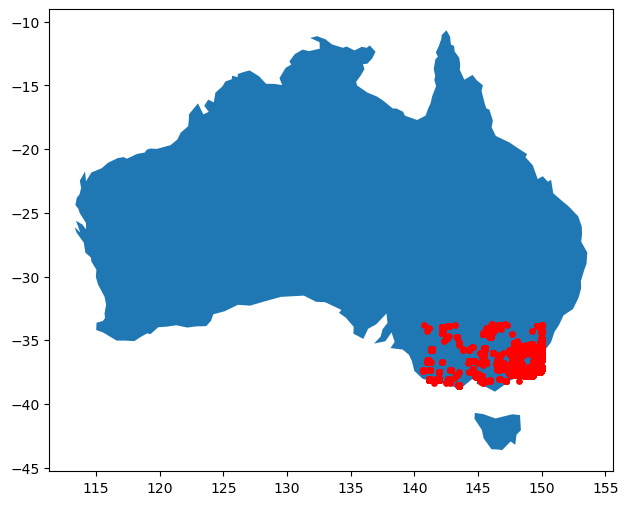

In [50]:
# Sort the valid hotspots
valid_hotspots = valid_hotspots.sort_values(by=['satellite', 'datetime'])
valid_hotspots = valid_hotspots.sort_values(by=['datetime'])

# Print the count of hotspots per satellite
uniq_sats = valid_hotspots.satellite.unique()
for s in uniq_sats:
    print(s, 'count =', (valid_hotspots.satellite == s).sum())

# Convert to GeoDataFrame for visualization
geometry = [Point(xy) for xy in zip(valid_hotspots['longitude'], valid_hotspots['latitude'])]
gdf = gpd.GeoDataFrame(valid_hotspots, geometry=geometry)

# Plot the hotspots on an Australia map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
australia = world.loc[world['name'] == 'Australia']
gdf.plot(ax=australia.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

if not plot_figs_here:
    # Save the resulting figure
    plt.savefig('hotspots_mapped.jpg')
    plt.close()


## Load and Filter MODIS MCD12C1 Land-Use Classification Data

In this section, we load the MODIS MCD12C1 Land-Use Classification data and filter it to keep only the relevant rows based on the defined Region of Interest (ROI) and target date.

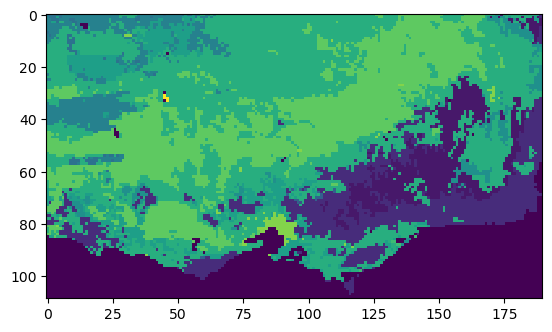

In [51]:
# Load the MODIS MCD12C1 land-use classification dataset
luc_mcd12c1_dataset = nc.Dataset('data/LUC/MCD12C1/MCD12C1.061.nc')

# Extract latitude, longitude, and date information
luc_mcd12c1_lon = luc_mcd12c1_dataset.variables['Longitude'][:].data
luc_mcd12c1_lat = luc_mcd12c1_dataset.variables['Latitude'][:].data
luc_mcd12c1_date = nc.num2date(luc_mcd12c1_dataset.variables['time'][:].data, luc_mcd12c1_dataset.variables['time'].units)

# Select a target date (one index per year)
target_luc_mcd12c1_date = cftime.real_datetime(2021, 1, 1, 0, 0, 0)
idate_luc_mcd12c1 = [d._to_real_datetime() for d in luc_mcd12c1_date].index(target_luc_mcd12c1_date)

# Select the ROI (Region of Interest)
roi_ixlim = np.searchsorted(luc_mcd12c1_lon, roi_lon_bounds)
roi_iylim = len(luc_mcd12c1_lat) - np.searchsorted(luc_mcd12c1_lat[::-1], roi_lat_bounds)

# Extract the relevant data based on ROI and date
luc_mcd12c1_roi_arr = luc_mcd12c1_dataset.variables['Majority_Land_Cover_Type_1'][idate_luc_mcd12c1, roi_iylim[1]:roi_iylim[0], roi_ixlim[0]:roi_ixlim[1]].data
luc_mcd12c1_dataset.close()

# Plot and save the ROI-specific land-use classification
res = plt.imshow(luc_mcd12c1_roi_arr, interpolation='nearest')
if not plot_figs_here:
    plt.savefig("luc_mcd12c1_roi_landsea.png")
    plt.close()

## Load and Filter ERA5 Hourly Weather Data

In this section, we load the ERA5 hourly weather data and filter it to keep only the relevant rows based on the defined Region of Interest (ROI) and study period.

In [52]:
# List available ERA5 variables
era5vars = os.listdir('data/weather/era5/australia')

# Initialize a dictionary to store the filtered data for each variable
era5_data = {}
era5_coord_vars = ['latitude', 'longitude', 'time']

# Loop through each ERA5 variable to load and filter data
for era5var in era5vars:
    print(f'Loading ERA5 variable {era5var}')
    ds = xarray.open_mfdataset(f'data/weather/era5/australia/{era5var}/2???/*.nc')
    era5_lat = ds.variables['latitude'].to_numpy()
    era5_lon = ds.variables['longitude'].to_numpy()
    era5_time = ds.variables['time'].to_numpy()

    # Determine indices for the ROI and study period
    roi_ixlim = np.searchsorted(era5_lon, roi_lon_bounds)
    roi_iylim = era5_lat.size - np.searchsorted(era5_lat[::-1], roi_lat_bounds[::-1])
    roi_itlim = np.searchsorted(era5_time, [t.to_numpy() for t in study_period_bounds])

    # Extract the actual variable name from the dataset
    era5varname = [vn for vn in list(ds.variables.keys()) if vn not in era5_coord_vars][0]

    # Extract and store the relevant data
    era5_data[era5var] = ds.variables[era5varname][roi_itlim[0]:roi_itlim[1], roi_iylim[0]:roi_iylim[1], roi_ixlim[0]:roi_ixlim[1]].to_numpy()

    ds.close()

Loading ERA5 variable mtpr
Loading ERA5 variable 10fg
Loading ERA5 variable lsm
Loading ERA5 variable 10v
Loading ERA5 variable 2d
Loading ERA5 variable 2t
Loading ERA5 variable mcpr
Loading ERA5 variable swvl1
Loading ERA5 variable 10u
Loading ERA5 variable cape
Loading ERA5 variable mlspr
Loading ERA5 variable blh


## Load and Filter AGCD Daily Weather Data

In this section, we load the AGCD daily weather data and filter it to keep only the relevant rows based on the defined Region of Interest (ROI) and study period.

In [ ]:
# List available AGCD variables
agcdvars = os.listdir('data/weather/agcd')

# Initialize a dictionary to store the filtered data for each variable
agcd_data = {}
agcd_coord_vars = ['lat', 'lon', 'time', 'lat_bnds', 'lon_bnds', 'time_bnds', 'crs']

# Loop through each AGCD variable to load and filter data
for agcdvar in agcdvars:
    ds = xarray.open_mfdataset(f'data/weather/agcd/{agcdvar}/*/r005/01day/*.nc')
    agcd_lat = ds.variables['lat'].to_numpy()
    agcd_lon = ds.variables['lon'].to_numpy()
    agcd_time = ds.variables['time'].to_numpy()

    # Determine indices for the ROI and study period
    roi_ixlim = np.searchsorted(agcd_lon, roi_lon_bounds)
    roi_iylim = np.searchsorted(agcd_lat, roi_lat_bounds)
    roi_itlim = np.searchsorted(agcd_time, [t.to_numpy() for t in study_period_bounds])

    # Extract the actual variable name from the dataset
    agcdvarname = [vn for vn in list(ds.variables.keys()) if vn not in agcd_coord_vars][0]

    # Extract and store the relevant data
    agcd_data[agcdvar] = ds.variables[agcdvarname][roi_itlim[0]:roi_itlim[1], roi_iylim[0]:roi_iylim[1], roi_ixlim[0]:roi_ixlim[1]].to_numpy()
    ds.close()


## BARRA Hourly Weather Data
Here, we are loading and processing BARRA hourly weather data. We will read the data, filter it based on the region of interest and study period, and store it for later use.


In [ ]:
# Import variable names from the BARRA dataset
barravars = [os.path.basename(f).replace('-PT1H-BARRA_R-v1-200001.nc', '').replace('-fc', '').replace('-spec', '').replace('-slv', '') for f in glob.glob('data/weather/barra/*-200001.nc')]
barravar = barravars[0]

# Initialize empty dictionary to store BARRA data
barra_data = {}

# Define coordinate variables used in the BARRA dataset
barra_coord_vars = ['lat', 'lon', 'time', 'lat_bnds', 'lon_bnds', 'time_bnds', 'crs']

# Load and sort the dataset files
fls = glob.glob(f'data/weather/barra/{barravar}*.nc')
fls.sort()

# Open and immediately close a sample dataset to initialize 'ds'
ds = xarray.open_mfdataset(fls[:119])  
ds.close()

# For some specific files, read the time data to ensure consistency
# (This section seems to be checking the time data for specific files)
fc = nc.Dataset(fls[120])
t120 = fc.variables['time'][:].data
fc.close()

fc = nc.Dataset(fls[121])
t121 = fc.variables['time'][:].data
fc.close()

fc = nc.Dataset(fls[122])
t122 = fc.variables['time'][:].data
fc.close()

fc = nc.Dataset(fls[123])
t123 = fc.variables['time'][:].data
fc.close()

np.all((t120[1:] - t120[:-1]) == 1.)
np.all((t121[1:] - t121[:-1]) == 1.)
np.all((t122[1:] - t122[:-1]) == 1.)
np.all((t123[1:] - t123[:-1]) == 1.)

# Loop through all variables in the BARRA dataset and perform data consistency checks
for barravar in barravars:
    fls = glob.glob(f'data/weather/barra/{barravar}*.nc')
    fls.sort()
    for fl in fls:
        fc = nc.Dataset(fl)
        t = fc.variables['time'][:].data
        fc.close()
        if not np.all((t[1:] - t[:-1]) == 1.):
            print(fl)


## Filter BARRA Data
Now, we filter the BARRA data based on the region of interest and study period.

In [ ]:
# Extract coordinate data
barra_lat = ds.variables['lat'].to_numpy()
barra_lon = ds.variables['lon'].to_numpy()
barra_time = ds.variables['time'].to_numpy()

# Find indices within ROI and study period
roi_ixlim = np.searchsorted(barra_lon, roi_lon_bounds)
roi_iylim = np.searchsorted(barra_lat, roi_lat_bounds)
roi_itlim = np.searchsorted(barra_time, [t.to_numpy() for t in study_period_bounds])

# Extract data based on the indices
barravarname = [vn for vn in list(ds.variables.keys()) if vn not in barra_coord_vars][0]
barra_data[barravar] = ds.variables[barravarname][roi_itlim[0]:roi_itlim[1], roi_iylim[0]:roi_iylim[1], roi_ixlim[0]:roi_ixlim[1]].to_numpy()

# Subset the time, longitude, and latitude arrays to match the ROI and study period
barra_time_subset = barra_time[roi_itlim[0]:roi_itlim[1]]
barra_lon_subset = barra_lon[roi_ixlim[0]:roi_ixlim[1]]
barra_lat_subset = barra_lat[roi_iylim[0]:roi_iylim[1]]

# Close the dataset
ds.close()

# Conclusion and Next Steps

## Summary

We have successfully read, transformed, and filtered multiple environmental datasets to gain insights into various environmental aspects. Through various data visualizations, we've been able to make some preliminary observations that can be valuable for future research and decision-making.

## Key Takeaways

1. **Data Versatility** - Working with multi-dimensional and geo-spatial data.
2. **Data Integration** - Successfully integrated different kinds of environmental data.
3. **Data Insights** - Extracted preliminary insights that can be valuable for researchers and policymakers.

## Limitations

While we were able to achieve a lot in this short time, there are some limitations:

1. Performance optimization is needed for faster data processing.
2. Further in-depth analysis can be conducted to derive more specific insights.

## Future Work

1. Apply machine learning models to predict future environmental changes based on the data.
2. Incorporate more datasets for a more comprehensive analysis.
3. Optimize the code for performance, especially the data filtering steps, which are currently time-consuming.

## Acknowledgments

We would like to thank all the organizers and mentors for their invaluable support and guidance.

## Contact Information

For any further queries or collaboration, feel free to contact us.

Thank you for taking the time to go through our project. We hope you found it insightful!
